In [75]:
from google.colab import files
uploaded = files.upload()


Saving AAPL.csv to AAPL.csv


In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [77]:
# Memuat dataset
data = pd.read_csv('AAPL.csv')

# Menampilkan beberapa baris pertama dari dataset
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


In [78]:
# Mengonversi kolom 'Date' menjadi tipe datetime
data['Date'] = pd.to_datetime(data['Date'])

# Menjadikan 'Date' sebagai index
data.set_index('Date', inplace=True)

# Menampilkan data setelah pengaturan index
data.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400


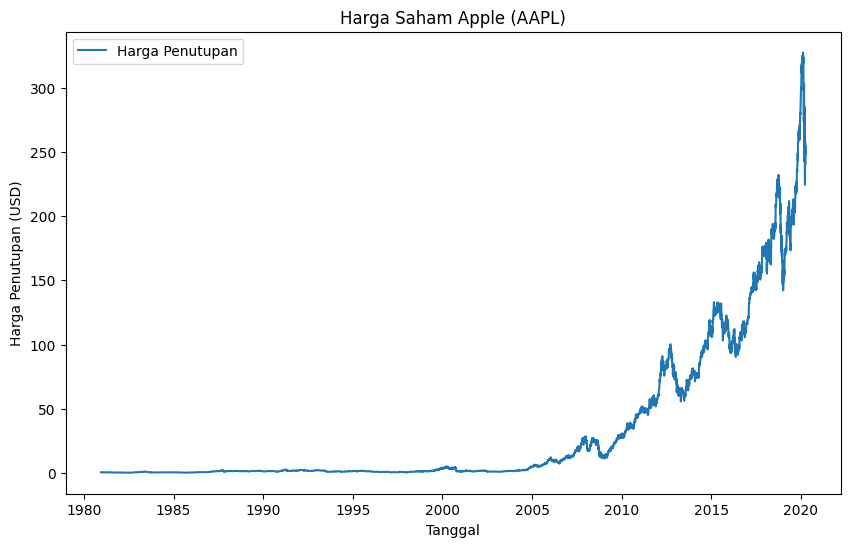

In [79]:
# Visualisasi harga penutupan saham
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Harga Penutupan')
plt.title('Harga Saham Apple (AAPL)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (USD)')
plt.legend()
plt.show()


In [81]:
# Mengambil kolom 'Close' sebagai target untuk peramalan
data_close = data[['Close']]

# Menggunakan MinMaxScaler untuk menskalakan data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# Membagi data menjadi data pelatihan dan pengujian (80%-20%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Fungsi untuk membuat dataset dengan window tertentu
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Mengambil data sebelumnya (60 hari)
        y.append(data[i, 0])  # Target adalah harga penutupan berikutnya
    return np.array(X), np.array(y)

# Membuat dataset untuk pelatihan dan pengujian
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Menambah dimensi agar sesuai dengan input LSTM (samples, time_step, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [82]:
# Membangun model LSTM
model = Sequential()

# Menambahkan LSTM pertama
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Menambahkan LSTM kedua
model.add(LSTM(units=50, return_sequences=False))

# Menambahkan layer Dense untuk output
model.add(Dense(units=1))

# Mengkompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 2.0817e-04
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 6.5339e-06
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - loss: 5.7961e-06
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 5.0518e-06
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 4.6884e-06
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 5.5573e-06
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 4.8501e-06
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 3.9164e-06
Epoch 9/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 4.6145e-06
Epoch 10/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 2.8848e-06


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


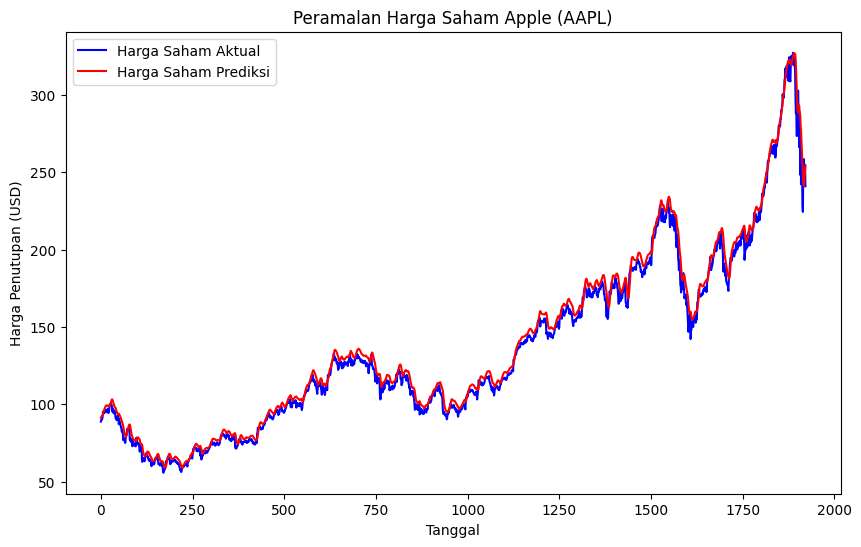

In [88]:
# Melakukan peramalan menggunakan data uji
predicted_price = model.predict(X_test)

# Menyusun hasil peramalan dan data aktual ke dalam bentuk yang dapat dibandingkan
predicted_price = scaler.inverse_transform(predicted_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisasi hasil peramalan
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Harga Saham Aktual')
plt.plot(predicted_price, color='red', label='Harga Saham Prediksi')
plt.title('Peramalan Harga Saham Apple (AAPL)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (USD)')
plt.legend()
plt.show()


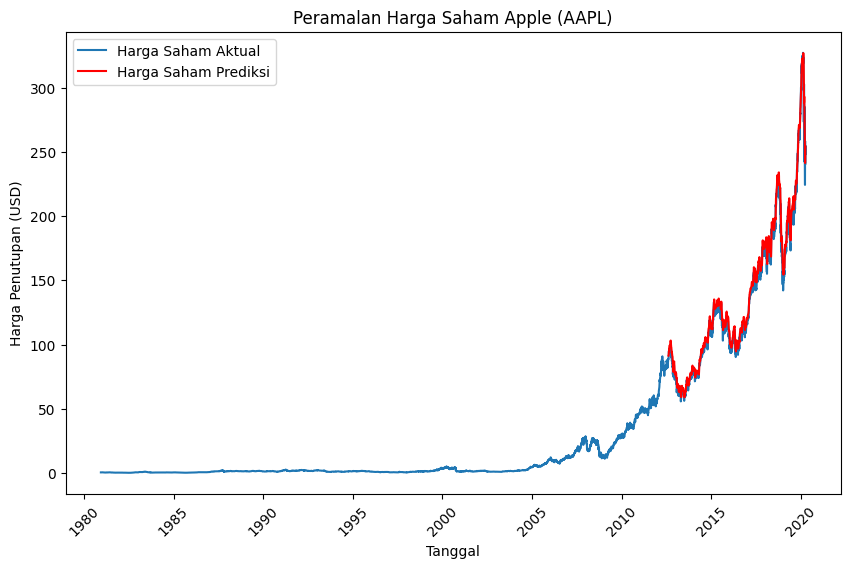

In [89]:
# Visualisasi harga penutupan saham dengan tanggal yang sebenarnya
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Harga Saham Aktual')
plt.plot(data.index[-len(predicted_price):], predicted_price, label='Harga Saham Prediksi', color='red')
plt.title('Peramalan Harga Saham Apple (AAPL)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (USD)')
plt.xticks(rotation=45)  # Memutar label tanggal agar lebih mudah dibaca
plt.legend()
plt.show()


In [84]:
from sklearn.metrics import mean_squared_error

# Menghitung MSE
mse = mean_squared_error(y_test_actual, predicted_price)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 30.252052625046502


In [86]:
# Menyimpan model dalam format Keras native
model.save('stock_price_predictor.keras')
